In [2]:
import tensorflow as tf
from tensorflow import keras
from keras.callbacks import History 

from random import randint
import numpy as np

import matplotlib.pyplot as plt

from skimage.filters import gaussian
from skimage.util import random_noise
import matplotlib.pyplot as pp

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier

from tensorflow.keras import datasets, layers, models
from xgboost import XGBClassifier
%matplotlib inline

# Reading the dataset:

In [3]:
import os
from tqdm import tqdm
from skimage.io import imread

# read all the images first
x_train = []
for i in range(1, 4): # changed to 3 classes
    base_dir = f'./cancer_data_hd/stage_{i}_png/'
    files = os.listdir(base_dir)
    for file in tqdm(files):
        img = imread(base_dir+file)
        x_train.append(img)
X_train = np.array(x_train)
X_train.shape

100%|██████████| 250/250 [00:00<00:00, 364.49it/s]


(750, 512, 512)

In [8]:
NUM = 250
CLASSES = 3 #4
y_train = []
class_label = 0
for i in range(NUM * CLASSES):
    if i > 0 and i %  NUM == 0:
        class_label += 1
    y_train.append(class_label)
Y_train = np.array(y_train)

In [9]:
# Shuffle training data
shuffler = np.random.permutation(NUM * CLASSES)

X_train = np.array(X_train)

shufled_X_train = X_train[shuffler]
shufled_Y_train = Y_train[shuffler]

0


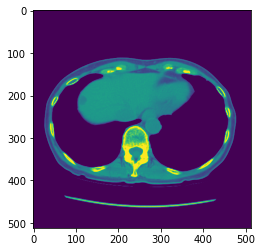

In [10]:
print(shufled_Y_train[100])
plt.imshow(shufled_X_train[100])

In [11]:
NUM_TRAIN = int(NUM * CLASSES * 0.85)

X_train = shufled_X_train[ : NUM_TRAIN]
Y_train = shufled_Y_train[ : NUM_TRAIN] 

X_test = shufled_X_train[NUM_TRAIN : ]
Y_test = shufled_Y_train[NUM_TRAIN:] 

# Building Model:

## Feature Exctraction(Convolutions):

In [12]:
WIDTH = 512
# Convolutional Network
feature_extractor = models.Sequential()
# Convolution and pooling layer
feature_extractor.add(layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(WIDTH, WIDTH, 1)))
feature_extractor.add(layers.MaxPooling2D((2, 2)))
# Convolution and pooling layer
feature_extractor.add(layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
feature_extractor.add(layers.MaxPooling2D((2, 2)))
# flattening layer
feature_extractor.add(layers.Flatten())

## Making a CNN using these features:

In [13]:
#Add layers for deep learning prediction
# Neural Network
# Connecting Convolutions output and adding two dense layers to it.
x = feature_extractor.output  
x = layers.Dense(64, activation='relu')(x)
prediction_layer = layers.Dense(3, activation='softmax')(x)

In [14]:
# Make a new model combining both feature extractor and x
cnn_model = models.Model(inputs=feature_extractor.input, outputs=prediction_layer)
cnn_model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
print(cnn_model.summary()) 

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_input (InputLayer)    [(None, 512, 512, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 510, 510, 32)      320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 255, 255, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 253, 253, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 126, 126, 64)      0         
_________________________________________________________________
flatten (Flatten)            (None, 1016064)           0         
_________________________________________________________________
dense (Dense)                (None, 64)               

In [15]:
# adding the extra dimension as required by the model
X_wanted_train = X_train.reshape(len(X_train), WIDTH, WIDTH, 1)
X_wanted_test = X_test.reshape(len(X_test), WIDTH, WIDTH, 1)

In [ ]:
#Train the CNN model
history = cnn_model.fit(X_wanted_train, Y_train, epochs=20, validation_data = (X_wanted_test, Y_test))

Epoch 1/20
20/20 [==============================] - 84s 4s/step - loss: 535.5613 - accuracy: 0.7645 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 2/20
20/20 [==============================] - 84s 4s/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 3/20
 7/20 [=========>....................] - ETA: 47s - loss: 0.0000e+00 - accuracy: 1.0000

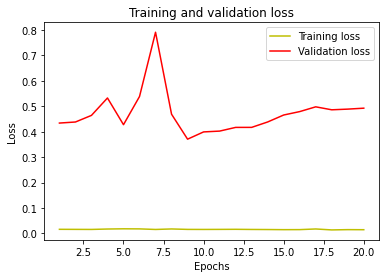

In [29]:
# plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

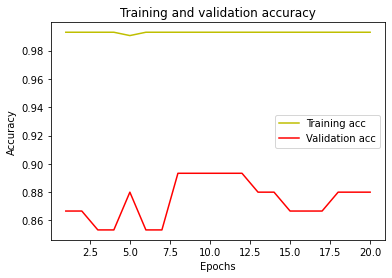

In [33]:
# plot the training and validation accuracy
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Classic models on convolved features:

In [44]:
# Now, let us use features from convolutional network for classic model
X_convolved_train = feature_extractor.predict(X_wanted_train) #This is out X input to RF

# Send test data through same feature extractor process
X_convolved_test = feature_extractor.predict(X_wanted_test)

X_convolved_train.shape

(425, 57600)

## Decision Tree:

In [61]:
from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier

# Create Decision Tree classifer object
clf = DecisionTreeClassifier()

# Train Decision Tree Classifer
clf = clf.fit(X_convolved_train, Y_train)

# Predict the response for test dataset
y_pred = clf.predict(X_convolved_test)

# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(Y_test, y_pred), end='\n\n')

print(classification_report(Y_test, y_pred))

Accuracy: 0.8266666666666667

              precision    recall  f1-score   support

           0       0.89      0.71      0.79        35
           1       0.79      0.93      0.85        40

    accuracy                           0.83        75
   macro avg       0.84      0.82      0.82        75
weighted avg       0.84      0.83      0.82        75



[Text(305.6544642857143, 214.9690909090909, 'X[57565] <= 0.01\ngini = 0.5\nsamples = 425\nvalue = [215, 210]'),
 Text(288.4660714285714, 210.02727272727273, 'X[47781] <= 0.041\ngini = 0.493\nsamples = 380\nvalue = [213, 167]'),
 Text(272.025, 205.08545454545455, 'X[39734] <= 0.051\ngini = 0.475\nsamples = 341\nvalue = [209, 132]'),
 Text(257.0785714285714, 200.14363636363635, 'X[43734] <= 0.15\ngini = 0.439\nsamples = 301\nvalue = [203, 98]'),
 Text(245.12142857142857, 195.20181818181817, 'X[55551] <= 0.056\ngini = 0.395\nsamples = 277\nvalue = [202, 75]'),
 Text(239.14285714285714, 190.26, 'X[7808] <= 0.002\ngini = 0.359\nsamples = 264\nvalue = [202, 62]'),
 Text(233.1642857142857, 185.3181818181818, 'X[31703] <= 0.149\ngini = 0.329\nsamples = 255\nvalue = [202, 53]'),
 Text(227.18571428571428, 180.37636363636364, 'X[23891] <= 0.181\ngini = 0.302\nsamples = 248\nvalue = [202, 46]'),
 Text(221.20714285714286, 175.43454545454546, 'X[33797] <= 0.315\ngini = 0.271\nsamples = 241\nvalue = 

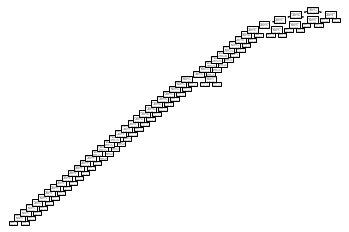

In [63]:
# plot tree
from sklearn import tree

tree.plot_tree(clf)

## Random Forest:

In [50]:
# Create Random Forest classifer object
clf = RandomForestClassifier(n_estimators = 50, random_state = 42)


# Train Random Forest Classifer
clf = clf.fit(X_convolved_train, Y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_convolved_test)

# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(Y_test, y_pred), end='\n\n')

print(classification_report(Y_test, y_pred))`

Accuracy: 0.8666666666666667

              precision    recall  f1-score   support

           0       0.90      0.80      0.85        35
           1       0.84      0.93      0.88        40

    accuracy                           0.87        75
   macro avg       0.87      0.86      0.86        75
weighted avg       0.87      0.87      0.87        75



### Increasing Estimators:

In [53]:
# Create Decision Tree classifer object
clf = RandomForestClassifier(n_estimators = 100, random_state = 42)


# Train Decision Tree Classifer
clf = clf.fit(X_convolved_train, Y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_convolved_test)

# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(Y_test, y_pred), end='\n\n')

print(classification_report(Y_test, y_pred))

Accuracy: 0.8666666666666667

              precision    recall  f1-score   support

           0       0.90      0.80      0.85        35
           1       0.84      0.93      0.88        40

    accuracy                           0.87        75
   macro avg       0.87      0.86      0.86        75
weighted avg       0.87      0.87      0.87        75



In [67]:
round(X_convolved_test.shape[0] * 0.87)

65

In [54]:
# Create Decision Tree classifer object
clf = RandomForestClassifier(n_estimators = 200, random_state = 42)


# Train Decision Tree Classifer
clf = clf.fit(X_convolved_train, Y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_convolved_test)

# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(Y_test, y_pred), end='\n\n')

print(classification_report(Y_test, y_pred))

Accuracy: 0.8533333333333334

              precision    recall  f1-score   support

           0       0.90      0.77      0.83        35
           1       0.82      0.93      0.87        40

    accuracy                           0.85        75
   macro avg       0.86      0.85      0.85        75
weighted avg       0.86      0.85      0.85        75



## Adaboost Classifier:

In [56]:
# Create AdaBoost classifier
clf = AdaBoostClassifier(n_estimators=42)


# Train AdaBoost classifier
clf = clf.fit(X_convolved_train, Y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_convolved_test)

# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(Y_test, y_pred), end='\n\n')

print(classification_report(Y_test, y_pred))

Accuracy: 0.8133333333333334

              precision    recall  f1-score   support

           0       0.77      0.86      0.81        35
           1       0.86      0.78      0.82        40

    accuracy                           0.81        75
   macro avg       0.82      0.82      0.81        75
weighted avg       0.82      0.81      0.81        75



In [58]:
# Create XG boost classifer object
clf = XGBClassifier()


# Train XGBoost Classifer
clf = clf.fit(X_convolved_train, Y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_convolved_test)

# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(Y_test, y_pred), end='\n\n')

print(classification_report(Y_test, y_pred))

/home/ahsanyleg/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:01:49] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy: 0.88

              precision    recall  f1-score   support

           0       0.91      0.83      0.87        35
           1       0.86      0.93      0.89        40

    accuracy                           0.88        75
   macro avg       0.88      0.88      0.88        75
weighted avg       0.88      0.88      0.88        75



## Gaussian Naive Bayes:

In [59]:
from sklearn.naive_bayes import GaussianNB

# Create Gaussian Naive Bayes Classifier
clf = GaussianNB()


# Train NB Classifier
clf = clf.fit(X_convolved_train, Y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_convolved_test)

# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(Y_test, y_pred), end='\n\n')

print(classification_report(Y_test, y_pred))
    

Accuracy: 0.72

              precision    recall  f1-score   support

           0       0.63      0.97      0.76        35
           1       0.95      0.50      0.66        40

    accuracy                           0.72        75
   macro avg       0.79      0.74      0.71        75
weighted avg       0.80      0.72      0.71        75



## Logistic Regression:

In [60]:
from sklearn.linear_model import LogisticRegression

# Create Logistic Regression Classifier
clf = LogisticRegression()


# Train Logistic Regression Classsifier
clf = clf.fit(X_convolved_train, Y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_convolved_test)

# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(Y_test, y_pred), end='\n\n')

print(classification_report(Y_test, y_pred))
    

Accuracy: 0.92

              precision    recall  f1-score   support

           0       0.94      0.89      0.91        35
           1       0.90      0.95      0.93        40

    accuracy                           0.92        75
   macro avg       0.92      0.92      0.92        75
weighted avg       0.92      0.92      0.92        75

